In [1]:
import numpy as np   # import numpy
import pandas as pd  # import pandas
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = r'C:\Users\csun\Downloads\transaction_fraud' 
df_i = pd.read_csv(DATA_PATH+r'\train_identity.csv')
df_t = pd.read_csv(DATA_PATH+r'\train_transaction.csv')

In [3]:
df_t['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

In [4]:
#change data type function
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [5]:
df_trans = reduce_mem_usage(df_t)
df_id = reduce_mem_usage(df_i)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [6]:
nan_info = pd.DataFrame(df_trans.isnull().sum()).reset_index()
nan_info.columns = ['feature_name','nan_cnt']
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info['nan_percentage'] = nan_info['nan_cnt']/len(df_trans)
nan_info.describe  

<bound method NDFrame.describe of      feature_name  nan_cnt  nan_percentage
14          dist2   552913        0.936284
37             D7   551623        0.934099
43            D13   528588        0.895093
44            D14   528353        0.894695
42            D12   525823        0.890410
..            ...      ...             ...
17             C1        0        0.000000
18             C2        0        0.000000
30            C14        0        0.000000
1         isFraud        0        0.000000
0   TransactionID        0        0.000000

[394 rows x 3 columns]>

In [7]:
#delete columns having >90% missing values
cols_with_missing = nan_info.loc[nan_info.nan_percentage>0.9].feature_name.values
df_tra = df_trans.drop(cols_with_missing,axis=1)

In [8]:
nan_info = pd.DataFrame(df_id.isnull().sum()).reset_index()
nan_info.columns = ['feature_name','nan_cnt']
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info['nan_percentage'] = nan_info['nan_cnt']/len(df_id)
nan_info.describe 
cols_with_missing_i = nan_info.loc[nan_info.nan_percentage>0.9].feature_name.values
df_ide = df_id.drop(cols_with_missing_i,axis=1)

In [9]:
# left join identity table to transaction
df = df_tra.merge(df_ide, how='left', on='TransactionID')

In [10]:
## Main Data
# 'TransactionID',                     
# 'isFraud',                           -> Target
# 'TransactionDT',                     -> Time from reference time point. VERY valuable column
# 'TransactionAmt',                   
# 'ProductCD',                         -> categorical feature
#                                     
# 'card1' - 'card6',                   -> Categorical features with information about Client
# 'addr1' - 'addr2',                   -> add2 - Country / addr1 - subzone
# 'dist1'                              -> dist2 - Country distance / dist1 - local distance from merchant
# 'P_emaildomain' - 'R_emaildomain',   -> Categorical feature. It's possible to make 
#                                         subgroup feature from it or general group
# 'C1' - 'C14'                         -> Counts. 
# 'D1' - 'D15'                         
# 'M1' - 'M9'                          ->  Categorical features
# 'V1' - 'V339'

## Identity Data
# 'TransactionID'
# 'id_01' - 'id_38'                       
# 'DeviceType',                          ->  Categorical features
# 'DeviceInfo'                           ->  Categorical features

In [11]:
#split email columns
df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)
df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)

In [22]:
pd.set_option("max_rows", 10)
pd.set_option("max_columns", 200)
df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,...,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,0.0,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,315.0,0.0,0.0,0.0,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outlook,com,None,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,8.0,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,43.0,0.0,0.0,0.0,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.

In [13]:
#obj_col = df.select_dtypes(include='O').columns float_col = df.select_dtypes(include='float').columns int_col = df.select_dtypes(include='int').columns

In [14]:
df_cols=df.columns
df_cols

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'P_emaildomain_1',
       'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1',
       'R_emaildomain_2', 'R_emaildomain_3'],
      dtype='object', length=429)

In [15]:
#categorical columns
cat_cols = ['id_12', 'id_15', 'id_16',  'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

In [16]:
# numerbical columns
num_cols = df_cols.drop(cat_cols)
num_cols 

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'dist1',
       'C1', 'C2', 'C3', 'C4', 'C5',
       ...
       'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18',
       'id_19', 'id_20'],
      dtype='object', length=387)

In [17]:
#fill in nulls by median
for col1 in num_cols :
    df[col1].fillna((df[col1].median()), inplace=True)

In [18]:
pd.set_option("max_rows", 10)
nan_info = pd.DataFrame(df.isnull().sum()).reset_index()
nan_info.columns = ['feature_name','nan_cnt']
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info['nan_percentage'] = nan_info['nan_cnt']/len(df)
nan_info.describe  

<bound method NDFrame.describe of         feature_name  nan_cnt  nan_percentage
428  R_emaildomain_3   587849        0.995443
425  P_emaildomain_3   587512        0.994872
415            id_33   517251        0.875895
412            id_30   512975        0.868654
414            id_32   512954        0.868619
..               ...      ...             ...
152             V100        0        0.000000
151              V99        0        0.000000
150              V98        0        0.000000
149              V97        0        0.000000
214             V162        0        0.000000

[429 rows x 3 columns]>

In [24]:
# re-define device names
df['device_name'] = df_id['DeviceInfo'].str.split('/', expand=True)[0]
df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung' 
df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung' 
df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung' 
df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola' 
df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola' 
df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola' 
df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG' 
df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV' 
df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei' 
df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei' 
df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei' 
df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE' 
df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name']= 'ZTE' 
df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux' 
df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony' 
df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC' 
df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others" 

In [25]:
df.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,...,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,device_name
0,2987000,0,86400,68.5000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,0.0,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Samsung
1,2987001,0,86401,29.0000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN,iOS Device
2,2987002,0,86469,59.0000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,315.0,0.0,0.0,0.0,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outlook,com,None,NaN,NaN,NaN,Windows
3,2987003,0,86499,50.0000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,8.0,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,43.0,0.0,0.0,0.0,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,

In [26]:
# re-set transaction date 
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df['_Weekdays'] = df['Date'].dt.dayofweek
df['_Hours'] = df['Date'].dt.hour
df['_Days'] = df['Date'].dt.day

In [27]:
df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,device_name,Date,_Weekdays,_Hours,_Days
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,0.0,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Samsung,2017-12-02 00:00:00,5,0,2
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN,iOS Device,2017-12-02 00:00:01,5,0,2
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,315.0,0.0,0.0,0.0,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,52.0,-300.0,NaN,NaN,166.0,15.0,341.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outlook,com,None,NaN,NaN,NaN,Windows,2017-12-02 00:01:09,5,0,2
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,8.0,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,43.0,0.0,0.0,0.0,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.

In [28]:
#Encode target labels for categorial columns
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col2 in cat_cols:
    if col2 in df.columns:
        
        le.fit(list(df[col2].astype(str).values))
        df[col2] = le.transform(list(df[col2].astype(str).values))
         

In [32]:
corr_matrix = df[df['isFraud'].notnull()].corr().abs()

In [33]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [35]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

to_drop.remove('TransactionDT')

In [67]:
df_prep = df.drop(columns = to_drop)


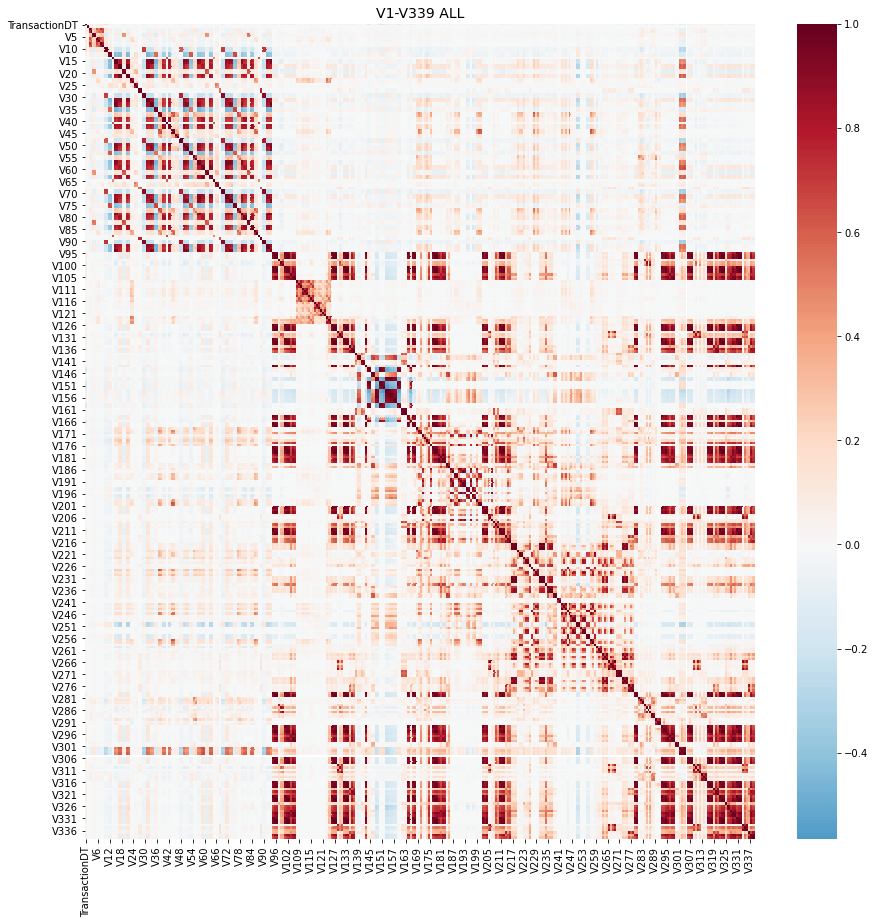

In [59]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
cols.remove('V107')
df2 = df[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(df2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()

def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df


mas_v = train.columns[55:393]

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))

    
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=30)
#df = reduce_mem_usage(df)

In [61]:
df['Trans_min_mean'] = df['TransactionAmt'] - df['TransactionAmt'].mean()
df['Trans_min_std'] = df['Trans_min_mean'] / df['TransactionAmt'].std()

df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / \
    df.groupby(['card1'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / \
    df.groupby(['card4'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / \
    df.groupby(['card1'])['TransactionAmt'].transform('std')
df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / \
    df.groupby(['card4'])['TransactionAmt'].transform('std')


In [62]:
df.drop(df[df.TransactionAmt>10000].index, axis=0, inplace=True)

In [63]:
def replacetodebit(row):
    if row==np.nan:
        return row
    if row=='debit or credit' or row=='charge card':
        return 'debit'
    else:
        return row
    
df['card6'] = df['card6'].apply(replacetodebit)


In [64]:
def new_card3(row):
    if row==np.nan:
        return row
    else:
        if row > 160:
            return 'Positive'
        else:
            return 'Negative'
        
df['new_card3'] = df['card3'].apply(new_card3)


In [66]:
df.drop(df[df.C1>3000].index, axis=0, inplace=True)
df.drop(df[df.C2>3000].index, axis=0, inplace=True)
df.drop(df[df.C7>1400].index, axis=0, inplace=True)
df.drop(df[df.C4>1400].index, axis=0, inplace=True)
df.drop(df[df.C6>1400].index, axis=0, inplace=True)
df.drop(df[df.C7>1400].index, axis=0, inplace=True)
df.drop(df[df.C8>1000].index, axis=0, inplace=True)
df.drop(df[df.C10>1000].index, axis=0, inplace=True)
df.drop(df[df.C11>2000].index, axis=0, inplace=True)
df.drop(df[df.C12>2000].index, axis=0, inplace=True)
df.drop(df[df.C13>1200].index, axis=0, inplace=True)
df.drop(df[df.C14>800].index, axis=0, inplace=True)

In [68]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,...,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,device_name,Date,_Weekdays,_Hours,_Days,Trans_min_mean,Trans_min_std,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,new_card3
0,2987000,0,86400,68.5,4,3417,500,42,1,38,1,166,65,19.0,32,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,13.0,0.0,0.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2,52.0,-300.0,3,2,166.0,15.0,341.0,472.0,2,2,74,103,4,260,4,2,2,2,2,2,1742,25,6,4,25,7,4,Samsung,2017-12-02 00:00:00,5,0,2,NaN,NaN,0.194580,0.257812,0.000000,0.000000,Negative
1,2987001,0,86401,29.0,4,7922,303,42,2,2,1,173,65,8.0,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,43.0,0.0,0.0,0.0,0.0,2,2,2,0,1,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2,52.0,-300.0,3,2,166.0,15.0,341.0,472.0,2,2,74,103,4,260,4,2,2,2,2,2,1742,15,2,0,25,7,4,iOS Device,2017-12-02 00:00:01,5,0,2,NaN,NaN,0.123779,0.219116,0.000000,0.114258,Negative
2,2987002,0,86469,59.0,4,9383,389,42,4,58,2,178,65,287.0,36,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,315.0,0.0,0.0,0.0,315.0,1,1,1,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2,52.0,-300.0,3,2,166.0,15.0,341.0,472.0,2,2,74,103,4,260,4,2,2,2,2,2,1742,28,2,0,25,7,4,Windows,2017-12-02 00:01:09,5,0,2,NaN,NaN,0.608398,0.443115,0.589355,0.258545,Negative
3,2987003,0,86499,50.0,4,6991,466,42,2,14,2,282,65,8.0,54,32,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,43.0,0.0,0.0,0.0,111.0,2,2,2,0,1,0,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,